Using the dataset from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! 

The file we are using contains a collection of more than 5 thousand SMS phone messages. Categorizing them as either spam or ham (not spam)

## Import the Data

In [1]:
# grabbing a list of all the lines of text messages

messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


In [2]:
# printing the first ten messages from the corpus

for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

In [3]:
import pandas as pd

In [4]:
# reading the labels and messages into a dataframe

messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
# creating a new feature length of text message

messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

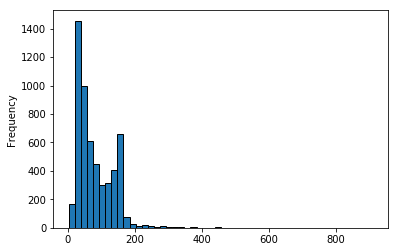

In [9]:
messages['length'].plot(bins=50, kind='hist', ec='black') 

In [10]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [11]:
# checking out the message that's 910 characters...

messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000011578E72978>,
      dtype=object)

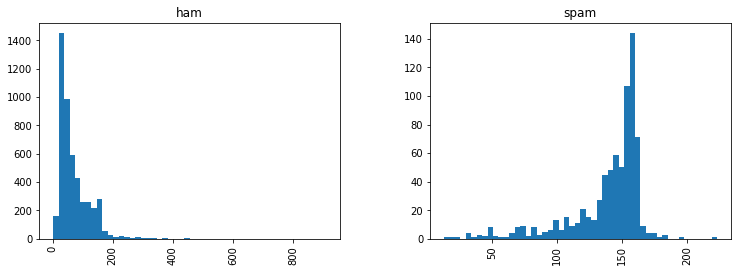

In [12]:
# checking out if text length is a good indicator of ham vs spam
# looks like spam messages tend to be longer

messages.hist(column='length', by='label', bins=50,figsize=(12,4))

## Text Preprocessing

To run the data through a classification algorithm need to create a numerical feature vector. Using bag of words to do this-- where each unique word in a text message is represented by one number.

So each raw message will be converted into a vector that is a sequence of numbers.

In [13]:
import string
import nltk
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords ie common words
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
# checking out original df for reference

messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
# tokenize the messages -- convert normal text strings into list of tokens (words) we want
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [16]:
# convert the list of tokens into a vector the models can use
# each vector will have as many dimensions as there are unique words in the corpus
# 2d matrix --> 1 row per word in entire vocabulary, columns are messages --> can expect a lot of zero counts

from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# Step 1: Count how many times a word occurs in each message 
# analyzer is our previously defined function

bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


In [18]:
messages_bow = bow_transformer.transform(messages['message'])

In [19]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [20]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [21]:
# Step 2: Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
# equation is log_e(Total number of documents / Number of documents with term t in it)


from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


In [22]:
# check out the IDF weight of the word u vs university

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


## Create a Pipeline

In [23]:
# now that messages are represented as vectors can create and train the model

from sklearn.naive_bayes import MultinomialNB

In [24]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [25]:
# creating a pipeline for the above steps to simplify future use

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x0000011578DA58C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [27]:
predictions = pipeline.predict(msg_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions, label_test))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.98      1027
       spam       0.72      1.00      0.83        88

avg / total       0.98      0.97      0.97      1115

[[992  35]
 [  0  88]]
